In [1]:
import sys
import os

# Add the `src` directory to Python's module search path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Go up one level from `notebooks`
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import gtfs_kit as gk
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional, Any
from datetime import datetime, timedelta
from abc import ABC, abstractmethod
import time
from shapely.geometry import Point, Polygon 
import matplotlib.pyplot as plt


from transit_opt.preprocessing.prepare_gtfs import GTFSDataPreparator

# Configure logging 
import logging
logging.basicConfig(level=logging.INFO)


## Load and Prepare GTFS Data

In [3]:
preparator = GTFSDataPreparator(
    gtfs_path='../data/external/study_area_gtfs_bus.zip',
    interval_hours=3,  # 8 periods per day
    date=None,  # Use full GTFS feed
    turnaround_buffer=1.15,  # 15% buffer
    max_round_trip_minutes= 240.0,  # Maximum round-trip time in minutes
    no_service_threshold_minutes= 480.0,  # Threshold for no-service mapping
    log_level="DEBUG"  # Use "INFO" for production, "DEBUG" for development
)

# Define allowed headways
allowed_headways = [10, 15, 30, 60, 120]
# Extract all data from the GTFS feed needed for optimization 
opt_data = preparator.extract_optimization_data(allowed_headways)


2025-08-26 14:30:27,764 - transit_opt.preprocessing.prepare_gtfs - INFO - Initializing GTFSDataPreparator with 3h intervals
INFO:transit_opt.preprocessing.prepare_gtfs:Initializing GTFSDataPreparator with 3h intervals
2025-08-26 14:30:27,766 - transit_opt.preprocessing.prepare_gtfs - DEBUG - Configuration: turnaround_buffer=1.15, max_round_trip=240.0min, no_service_threshold=480.0min
DEBUG:transit_opt.preprocessing.prepare_gtfs:Configuration: turnaround_buffer=1.15, max_round_trip=240.0min, no_service_threshold=480.0min
2025-08-26 14:30:27,767 - transit_opt.preprocessing.prepare_gtfs - INFO - Loading GTFS feed from ../data/external/study_area_gtfs_bus.zip
INFO:transit_opt.preprocessing.prepare_gtfs:Loading GTFS feed from ../data/external/study_area_gtfs_bus.zip
2025-08-26 14:30:30,481 - transit_opt.preprocessing.prepare_gtfs - DEBUG - GTFS feed loaded successfully: 187 routes, 13974 trips
DEBUG:transit_opt.preprocessing.prepare_gtfs:GTFS feed loaded successfully: 187 routes, 13974 trip

### Exploration of current service patterns

In [4]:
# =============================================================================
# DATA EXPLORATION: Understanding the Optimization Data Structure
# =============================================================================

print("=== OPTIMIZATION DATA OVERVIEW ===")
print(f"Problem Type: {opt_data['problem_type']}")
print(f"Decision Matrix Shape: {opt_data['decision_matrix_shape']}")
print(f"Variable Bounds: {opt_data['variable_bounds']}")
print(f"Number of Discrete Choices: {opt_data['n_choices']}")

print(f"\n=== ALLOWED HEADWAYS ===")
for i, headway in enumerate(opt_data['allowed_headways']):
    if headway >= 9000:
        print(f"  Index {i}: No Service ({headway})")
    else:
        print(f"  Index {i}: {headway:.0f} minutes")

print(f"\n=== TIME INTERVALS ===")
for i, (label, hours) in enumerate(zip(opt_data['intervals']['labels'], opt_data['intervals']['hours'])):
    print(f"  Interval {i}: {label} ({hours[0]:02d}:00-{hours[1]:02d}:00)")

=== OPTIMIZATION DATA OVERVIEW ===
Problem Type: discrete_headway_optimization
Decision Matrix Shape: (141, 8)
Variable Bounds: (0, 5)
Number of Discrete Choices: 6

=== ALLOWED HEADWAYS ===
  Index 0: 10 minutes
  Index 1: 15 minutes
  Index 2: 30 minutes
  Index 3: 60 minutes
  Index 4: 120 minutes
  Index 5: No Service (9999.0)

=== TIME INTERVALS ===
  Interval 0: 00-03h (00:00-03:00)
  Interval 1: 03-06h (03:00-06:00)
  Interval 2: 06-09h (06:00-09:00)
  Interval 3: 09-12h (09:00-12:00)
  Interval 4: 12-15h (12:00-15:00)
  Interval 5: 15-18h (15:00-18:00)
  Interval 6: 18-21h (18:00-21:00)
  Interval 7: 21-24h (21:00-24:00)


In [5]:
# =============================================================================
# ROUTE CHARACTERISTICS ANALYSIS
# =============================================================================

route_ids = opt_data['routes']['ids']
round_trip_times = opt_data['routes']['round_trip_times']
current_headways = opt_data['routes']['current_headways']

print("=== ROUTE CHARACTERISTICS ===")
print(f"Total Routes: {len(route_ids)}")

print(f"\n🚌 ROUND-TRIP TIME DISTRIBUTION:")
print(f"  Min: {np.min(round_trip_times):.1f} minutes")
print(f"  Mean: {np.mean(round_trip_times):.1f} minutes")
print(f"  Median: {np.median(round_trip_times):.1f} minutes")
print(f"  Max: {np.max(round_trip_times):.1f} minutes")

# Categorize routes by round-trip time
short_routes = np.sum(round_trip_times <= 60)
medium_routes = np.sum((round_trip_times > 60) & (round_trip_times <= 120))
long_routes = np.sum(round_trip_times > 120)

print(f"\n🚌 ROUTE CATEGORIES BY DURATION:")
print(f"  Short Routes (≤60min): {short_routes} ({100*short_routes/len(route_ids):.1f}%)")
print(f"  Medium Routes (60-120min): {medium_routes} ({100*medium_routes/len(route_ids):.1f}%)")
print(f"  Long Routes (>120min): {long_routes} ({100*long_routes/len(route_ids):.1f}%)")

print(f"\n📊 SERVICE COVERAGE BY INTERVAL:")
for i, label in enumerate(opt_data['intervals']['labels']):
    active_routes = np.sum(~np.isnan(current_headways[:, i]))
    coverage_pct = 100 * active_routes / len(route_ids)
    print(f"  {label}: {active_routes}/{len(route_ids)} routes active ({coverage_pct:.1f}%)")

=== ROUTE CHARACTERISTICS ===
Total Routes: 141

🚌 ROUND-TRIP TIME DISTRIBUTION:
  Min: 13.8 minutes
  Mean: 115.2 minutes
  Median: 110.4 minutes
  Max: 239.2 minutes

🚌 ROUTE CATEGORIES BY DURATION:
  Short Routes (≤60min): 20 (14.2%)
  Medium Routes (60-120min): 61 (43.3%)
  Long Routes (>120min): 60 (42.6%)

📊 SERVICE COVERAGE BY INTERVAL:
  00-03h: 9/141 routes active (6.4%)
  03-06h: 38/141 routes active (27.0%)
  06-09h: 106/141 routes active (75.2%)
  09-12h: 86/141 routes active (61.0%)
  12-15h: 94/141 routes active (66.7%)
  15-18h: 106/141 routes active (75.2%)
  18-21h: 74/141 routes active (52.5%)
  21-24h: 48/141 routes active (34.0%)


In [6]:
# =============================================================================
# CURRENT HEADWAY PATTERNS ANALYSIS
# =============================================================================

print("=== CURRENT HEADWAY PATTERNS ===")

# Overall statistics - Filter out extreme values using threshold
valid_headways = current_headways[~np.isnan(current_headways)]
# Filter out values above the no-service threshold (typically 480 minutes = 8 hours)
regular_service_headways = valid_headways[valid_headways < preparator.no_service_threshold_minutes]

if len(regular_service_headways) > 0:
    print(f"\n📈 HEADWAY STATISTICS (regular service only, <{preparator.no_service_threshold_minutes:.0f}min):")
    print(f"  Min: {np.min(regular_service_headways):.1f} minutes")
    print(f"  Mean: {np.mean(regular_service_headways):.1f} minutes")
    print(f"  Median: {np.median(regular_service_headways):.1f} minutes")
    print(f"  Max: {np.max(regular_service_headways):.1f} minutes")
    print(f"  Count: {len(regular_service_headways):,} intervals (vs {len(valid_headways):,} total)")
    
    # Headway distribution (using regular service only)
    frequent = np.sum(regular_service_headways <= 15)
    moderate = np.sum((regular_service_headways > 15) & (regular_service_headways <= 60))
    infrequent = np.sum(regular_service_headways > 60)
    
    print(f"\n📊 SERVICE FREQUENCY DISTRIBUTION (regular service):")
    print(f"  Frequent Service (≤15min): {frequent} ({100*frequent/len(regular_service_headways):.1f}%)")
    print(f"  Moderate Service (15-60min): {moderate} ({100*moderate/len(regular_service_headways):.1f}%)")
    print(f"  Infrequent Service (>60min): {infrequent} ({100*infrequent/len(regular_service_headways):.1f}%)")
    
    # Show extreme values separately
    extreme_headways = valid_headways[valid_headways >= preparator.no_service_threshold_minutes]
    if len(extreme_headways) > 0:
        print(f"\n⚠️  IRREGULAR SERVICE (≥{preparator.no_service_threshold_minutes:.0f}min): {len(extreme_headways)} intervals")
        print(f"  These represent once-daily, once-weekly, or irregular services")
        print(f"  Values: {np.unique(extreme_headways)[:5]} {'...' if len(np.unique(extreme_headways)) > 5 else ''}")

else:
    print(f"\n⚠️  No regular service found (all headways ≥{preparator.no_service_threshold_minutes:.0f}min)")

# Service patterns by time of day (also filter extreme values)
print(f"\n🕐 AVERAGE HEADWAYS BY TIME OF DAY (regular service only):")
for i, label in enumerate(opt_data['intervals']['labels']):
    interval_headways = current_headways[:, i]
    valid_interval = interval_headways[~np.isnan(interval_headways)]
    regular_interval = valid_interval[valid_interval < preparator.no_service_threshold_minutes]
    
    if len(regular_interval) > 0:
        avg_headway = np.mean(regular_interval)
        print(f"  {label}: {avg_headway:.1f} min average ({len(regular_interval)} regular routes, {len(valid_interval)-len(regular_interval)} irregular)")
    elif len(valid_interval) > 0:
        irregular_count = len(valid_interval) - len(regular_interval)
        print(f"  {label}: No regular service ({irregular_count} irregular routes)")
    else:
        print(f"  {label}: No active routes")

=== CURRENT HEADWAY PATTERNS ===

📈 HEADWAY STATISTICS (regular service only, <480min):
  Min: 1.0 minutes
  Mean: 22.2 minutes
  Median: 17.2 minutes
  Max: 125.0 minutes
  Count: 459 intervals (vs 561 total)

📊 SERVICE FREQUENCY DISTRIBUTION (regular service):
  Frequent Service (≤15min): 214 (46.6%)
  Moderate Service (15-60min): 235 (51.2%)
  Infrequent Service (>60min): 10 (2.2%)

⚠️  IRREGULAR SERVICE (≥480min): 102 intervals
  These represent once-daily, once-weekly, or irregular services
  Values: [1440.] 

🕐 AVERAGE HEADWAYS BY TIME OF DAY (regular service only):
  00-03h: 31.7 min average (6 regular routes, 3 irregular)
  03-06h: 20.3 min average (27 regular routes, 11 irregular)
  06-09h: 19.5 min average (73 regular routes, 33 irregular)
  09-12h: 25.3 min average (83 regular routes, 3 irregular)
  12-15h: 23.9 min average (85 regular routes, 9 irregular)
  15-18h: 22.0 min average (84 regular routes, 22 irregular)
  18-21h: 21.2 min average (66 regular routes, 8 irregular)

In [7]:
# =============================================================================
# INITIAL SOLUTION ANALYSIS
# =============================================================================

initial_solution = opt_data['initial_solution']
allowed_headways = opt_data['allowed_headways']

print("=== INITIAL SOLUTION MAPPING ===")
print("How current GTFS headways map to discrete choices:\n")

# Count frequency of each choice in initial solution
choice_counts = {}
for choice_idx in range(opt_data['n_choices']):
    count = np.sum(initial_solution == choice_idx)
    choice_counts[choice_idx] = count

# Display mapping statistics
total_cells = initial_solution.size
for choice_idx in sorted(choice_counts.keys()):
    count = choice_counts[choice_idx]
    percentage = 100 * count / total_cells
    headway_val = allowed_headways[choice_idx]
    
    if headway_val >= 9000:
        print(f"  Choice {choice_idx} (No Service): {count:,} cells ({percentage:.1f}%)")
    else:
        print(f"  Choice {choice_idx} ({headway_val:.0f}min): {count:,} cells ({percentage:.1f}%)")

service_cells = total_cells - choice_counts.get(opt_data['no_service_index'], 0)
print(f"\nOverall: {service_cells:,}/{total_cells:,} cells with active service ({100*service_cells/total_cells:.1f}%)")

=== INITIAL SOLUTION MAPPING ===
How current GTFS headways map to discrete choices:

  Choice 0 (10min): 183 cells (16.2%)
  Choice 1 (15min): 88 cells (7.8%)
  Choice 2 (30min): 134 cells (11.9%)
  Choice 3 (60min): 52 cells (4.6%)
  Choice 4 (120min): 2 cells (0.2%)
  Choice 5 (No Service): 669 cells (59.3%)

Overall: 459/1,128 cells with active service (40.7%)


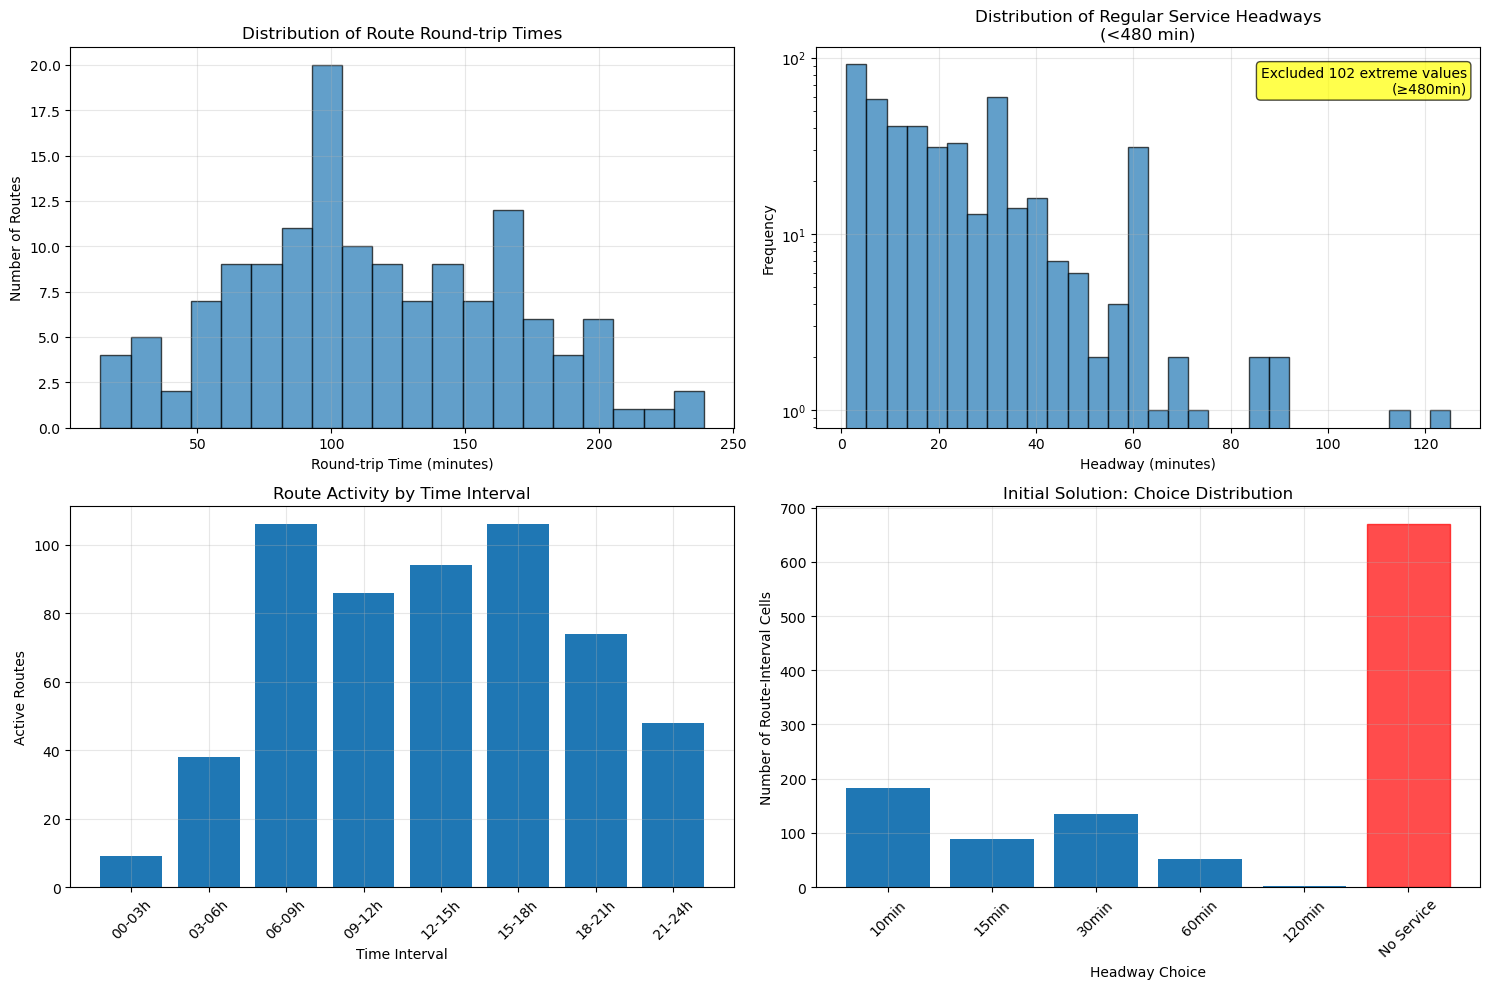


Visualization shows:
  • Route complexity (round-trip times)
  • Regular service frequency patterns (extreme values filtered)
  • When routes are most/least active
  • How existing service maps to optimization choices


In [ ]:
# =============================================================================
# VISUALIZE CURRENT SERVICE PATTERNS
# =============================================================================

# Create a comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Round-trip time distribution (unchanged)
axes[0,0].hist(round_trip_times, bins=20, alpha=0.7, edgecolor='black')
axes[0,0].set_xlabel('Round-trip Time (minutes)')
axes[0,0].set_ylabel('Number of Routes')
axes[0,0].set_title('Distribution of Route Round-trip Times')
axes[0,0].grid(True, alpha=0.3)

# 2. Valid headways distribution - filter extreme values
valid_headways = current_headways[~np.isnan(current_headways)]
regular_service_headways = valid_headways[valid_headways < preparator.no_service_threshold_minutes]

if len(regular_service_headways) > 0:
    axes[0,1].hist(regular_service_headways, bins=30, alpha=0.7, edgecolor='black')
    axes[0,1].set_xlabel('Headway (minutes)')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title(f'Distribution of Regular Service Headways\n(<{preparator.no_service_threshold_minutes:.0f} min)')
    axes[0,1].set_yscale('log')
    axes[0,1].grid(True, alpha=0.3)
    
    # Add text showing filtered count
    extreme_count = len(valid_headways) - len(regular_service_headways)
    axes[0,1].text(0.98, 0.95, f'Excluded {extreme_count} extreme values\n(≥{preparator.no_service_threshold_minutes:.0f}min)', 
                   transform=axes[0,1].transAxes, ha='right', va='top',
                   bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
else:
    axes[0,1].text(0.5, 0.5, 'No Regular Service\nFound', 
                   ha='center', va='center', transform=axes[0,1].transAxes)
    axes[0,1].set_title('Distribution of Regular Service Headways')

# 3. Service coverage by interval (unchanged)
interval_labels = opt_data['intervals']['labels']
active_counts = [np.sum(~np.isnan(current_headways[:, i])) for i in range(opt_data['n_intervals'])]

axes[1,0].bar(range(len(active_counts)), active_counts)
axes[1,0].set_xlabel('Time Interval')
axes[1,0].set_ylabel('Active Routes')
axes[1,0].set_title('Route Activity by Time Interval')
axes[1,0].set_xticks(range(len(interval_labels)))
axes[1,0].set_xticklabels(interval_labels, rotation=45)
axes[1,0].grid(True, alpha=0.3)

# 4. Initial solution choice distribution (unchanged)
choice_labels = [f"{h:.0f}min" if h < 9000 else "No Service" for h in allowed_headways]
choice_counts_list = [choice_counts.get(i, 0) for i in range(opt_data['n_choices'])]

bars = axes[1,1].bar(range(len(choice_counts_list)), choice_counts_list)
axes[1,1].set_xlabel('Headway Choice')
axes[1,1].set_ylabel('Number of Route-Interval Cells')
axes[1,1].set_title('Initial Solution: Choice Distribution')
axes[1,1].set_xticks(range(len(choice_labels)))
axes[1,1].set_xticklabels(choice_labels, rotation=45)

# Highlight no-service bar
bars[opt_data['no_service_index']].set_color('red')
bars[opt_data['no_service_index']].set_alpha(0.7)

axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nVisualization shows:")
print(f"  • Route complexity (round-trip times)")
print(f"  • Regular service frequency patterns (extreme values filtered)")
print(f"  • When routes are most/least active")
print(f"  • How existing service maps to optimization choices")

### Fleet analysis

Check the `fleet_analysis` output to see the fleet requirements of the existing service

In [9]:
# Comprehensive fleet analysis display
fleet_analysis = opt_data['constraints']['fleet_analysis']

print("=== FLEET ANALYSIS SUMMARY ===")
print(f"📊 Total Routes: {opt_data['n_routes']}")
print(f"📊 Active Routes: {fleet_analysis['fleet_stats']['routes_with_service']}")
print(f"📊 Time Intervals: {opt_data['n_intervals']} ({opt_data['intervals']['duration_minutes']//60}h each)")

print(f"\n🚗 FLEET REQUIREMENTS:")
print(f"Peak Fleet Needed: {fleet_analysis['total_current_fleet_peak']} vehicles")
print(f"Fleet by Interval: {fleet_analysis['current_fleet_by_interval'].tolist()}")
print(f"Peak Interval: {fleet_analysis['fleet_stats']['peak_interval']} ({opt_data['intervals']['labels'][fleet_analysis['fleet_stats']['peak_interval']]})")
print(f"Off-Peak Minimum: {fleet_analysis['fleet_stats']['off_peak_fleet']} vehicles")

print(f"\n📈 EFFICIENCY:")
efficiency_gain = fleet_analysis['fleet_stats']['fleet_efficiency_gain']
if efficiency_gain > 0:
    print(f"Efficiency Gain: {efficiency_gain} vehicles saved ({efficiency_gain/(fleet_analysis['total_current_fleet_peak']+efficiency_gain)*100:.1f}% reduction)")
else:
    print(f"No efficiency gain (all routes peak simultaneously)")

print(f"\n🔧 ROUTE DISTRIBUTION:")
dist = fleet_analysis['fleet_stats']['fleet_distribution']
print(f"Small Routes (1-5 vehicles): {dist['small_routes']}")
print(f"Medium Routes (6-15 vehicles): {dist['medium_routes']}")
print(f"Large Routes (>15 vehicles): {dist['large_routes']}")

print(f"\n⚙️ CONFIGURATION:")
print(f"Operational Buffer: {fleet_analysis['operational_buffer']} ({(fleet_analysis['operational_buffer']-1)*100:.0f}% extra time)")

=== FLEET ANALYSIS SUMMARY ===
📊 Total Routes: 141
📊 Active Routes: 141
📊 Time Intervals: 8 (3h each)

🚗 FLEET REQUIREMENTS:
Peak Fleet Needed: 1653 vehicles
Fleet by Interval: [29, 434, 1351, 1469, 1582, 1653, 1071, 670]
Peak Interval: 5 (15-18h)
Off-Peak Minimum: 29 vehicles

📈 EFFICIENCY:
Efficiency Gain: 418 vehicles saved (20.2% reduction)

🔧 ROUTE DISTRIBUTION:
Small Routes (1-5 vehicles): 72
Medium Routes (6-15 vehicles): 33
Large Routes (>15 vehicles): 36

⚙️ CONFIGURATION:
Operational Buffer: 1.15 (15% extra time)


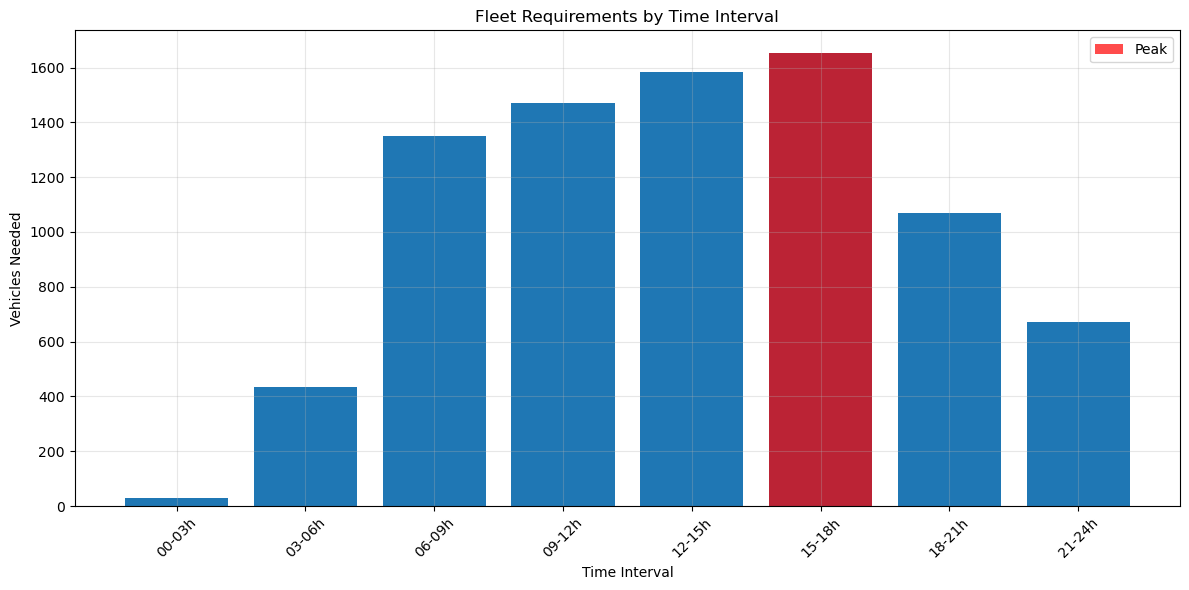

Peak occurs during 15-18h with 1653 vehicles needed


In [10]:
# Plot fleet requirements by interval
import matplotlib.pyplot as plt

fleet_by_interval = fleet_analysis['current_fleet_by_interval']
interval_labels = opt_data['intervals']['labels']

plt.figure(figsize=(12, 6))
plt.bar(range(len(fleet_by_interval)), fleet_by_interval)
plt.xlabel('Time Interval')
plt.ylabel('Vehicles Needed')
plt.title('Fleet Requirements by Time Interval')
plt.xticks(range(len(interval_labels)), interval_labels, rotation=45)
plt.grid(True, alpha=0.3)

# Highlight peak interval
peak_idx = fleet_analysis['fleet_stats']['peak_interval']
plt.bar(peak_idx, fleet_by_interval[peak_idx], color='red', alpha=0.7, label='Peak')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Peak occurs during {interval_labels[peak_idx]} with {fleet_by_interval[peak_idx]} vehicles needed")

## Objective functions

### Spatial coverage

In [75]:
class HexagonalZoneSystem:
    """
    Optimized hexagonal zoning system using spatial indexing with metric CRS.
    """
    
    def __init__(self, 
                 gtfs_feed,
                 hex_size_km: float = 2.0,
                 crs: str = "EPSG:3857",
                 boundary: Optional['StudyAreaBoundary'] = None):
        self.gtfs_feed = gtfs_feed
        self.hex_size_km = hex_size_km
        self.crs = crs
        self.boundary = boundary

        
        # Validate that CRS is metric
        self._validate_metric_crs()
        
        # Create stop locations GeoDataFrame
        self.stops_gdf = self._create_stops_geodataframe()
    
        # Apply boundary filtering if provided
        if self.boundary is not None:
            print(f"🎯 Applying boundary filter to {len(self.stops_gdf)} stops...")
            self.stops_gdf = self.boundary.filter_points(
                self.stops_gdf, 
                output_crs=self.crs
            )
            print(f"✅ Filtered to {len(self.stops_gdf)} stops within boundary")
        
        
        # Generate hexagonal grid
        self.hex_grid = self._create_hexagonal_grid()
        
                # Optionally filter grid to boundary as well
        if self.boundary is not None:
            print(f"🎯 Applying boundary filter to {len(self.hex_grid)} grid cells...")
            self.hex_grid = self.boundary.filter_grid(
                self.hex_grid, 
                predicate="intersects",
                output_crs=self.crs
            )
            print(f"✅ Filtered to {len(self.hex_grid)} grid cells within boundary")
        
        # OPTIMIZED: Use spatial join instead of nested loops
        self.stop_zone_mapping = self._fast_map_stops_to_zones()
        
        # OPTIMIZED: Pre-compute route-stop mappings
        self._precompute_route_stop_mappings()
    
    def _validate_metric_crs(self):
        """Validate that the CRS uses metric units."""
        try:
            import pyproj
            crs_info = pyproj.CRS(self.crs)
            
            # Check if units are metric
            if hasattr(crs_info.axis_info[0], 'unit_name'):
                unit = crs_info.axis_info[0].unit_name.lower()
                if 'metre' not in unit and 'meter' not in unit:
                    print(f"⚠️  Warning: CRS {self.crs} may not be metric (units: {unit})")
                    print("   Consider using EPSG:3857 (Web Mercator) or a local UTM zone")
            
        except ImportError:
            print("⚠️  pyproj not available - cannot validate CRS units")
        except Exception as e:
            print(f"⚠️  Could not validate CRS {self.crs}: {e}")
    
    def _create_stops_geodataframe(self) -> gpd.GeoDataFrame:
        """Create stops GeoDataFrame and reproject to metric CRS."""
        stops = self.gtfs_feed.stops.copy()
        
        # Create geometry from lat/lon (EPSG:4326)
        geometry = [Point(lon, lat) for lon, lat in zip(stops['stop_lon'], stops['stop_lat'])]
        stops_gdf = gpd.GeoDataFrame(stops, geometry=geometry, crs="EPSG:4326")
        
        # Reproject to target metric CRS
        stops_gdf = stops_gdf.to_crs(self.crs)
        
        print(f"🗺️  Reprojected {len(stops_gdf)} stops to {self.crs}")
        return stops_gdf
    
    def _create_hexagonal_grid(self) -> gpd.GeoDataFrame:
        """
        Create hexagonal grid using metric coordinates.
        """
        bounds = self.stops_gdf.total_bounds
        
        # Convert km to meters (since we're now using metric CRS)
        hex_size_m = self.hex_size_km * 1000
        buffer_m = hex_size_m * 0.5  # 50% buffer
        
        minx, miny, maxx, maxy = bounds
        minx -= buffer_m
        miny -= buffer_m  
        maxx += buffer_m
        maxy += buffer_m
        
        hex_polygons = []
        zone_ids = []
        
        # Calculate steps using metric coordinates
        x_steps = int((maxx - minx) / hex_size_m) + 1
        y_steps = int((maxy - miny) / hex_size_m) + 1
        
        print(f"🔧 Creating {x_steps} × {y_steps} = {x_steps * y_steps} grid cells")
        print(f"   Grid bounds: ({minx:.0f}, {miny:.0f}) to ({maxx:.0f}, {maxy:.0f}) meters")
        print(f"   Cell size: {hex_size_m}m × {hex_size_m}m")
        
        zone_id = 0
        for i in range(x_steps):
            for j in range(y_steps):
                x = minx + i * hex_size_m
                y = miny + j * hex_size_m
                
                # Create square cells (TODO: implement proper hexagons)
                from shapely.geometry import Polygon
                cell = Polygon([
                    (x, y), 
                    (x + hex_size_m, y),
                    (x + hex_size_m, y + hex_size_m),
                    (x, y + hex_size_m)
                ])
                
                hex_polygons.append(cell)
                zone_ids.append(f"zone_{zone_id}")
                zone_id += 1
        
        hex_gdf = gpd.GeoDataFrame({
            'zone_id': zone_ids,
            'geometry': hex_polygons
        }, crs=self.crs)
        
        print(f"✅ Created {len(hex_gdf)} hexagonal zones in {self.crs}")
        return hex_gdf
    
    def _fast_map_stops_to_zones(self) -> Dict[str, str]:
        """
        OPTIMIZED: Use spatial join - O(S + Z) instead of O(S × Z).
        """
        print("🚀 Using spatial join for zone mapping...")
        
        # Spatial join: finds containing zone for each stop in one operation
        stops_with_zones = gpd.sjoin(
            self.stops_gdf, 
            self.hex_grid, 
            how='left', 
            predicate='within'
        )
        
        # Convert to dictionary
        stop_zone_map = {}
        for idx, row in stops_with_zones.iterrows():
            if pd.notna(row['zone_id']):
                stop_zone_map[row['stop_id']] = row['zone_id']
            else:
                # Handle stops not in any zone (find nearest)
                stop_point = row.geometry
                distances = self.hex_grid.geometry.distance(stop_point)
                nearest_zone_idx = distances.idxmin()
                stop_zone_map[row['stop_id']] = self.hex_grid.loc[nearest_zone_idx, 'zone_id']
        
        print(f"✅ Mapped {len(stop_zone_map)} stops to zones")
        return stop_zone_map
    
    def _precompute_route_stop_mappings(self):
        """
        OPTIMIZED: Pre-compute all route → stops mappings to avoid repeated filtering.
        """
        print("🚀 Pre-computing route-stop mappings...")
        
        self.route_stops_cache = {}
        
        # Group trips by service_id once
        trips_by_service = self.gtfs_feed.trips.groupby('service_id')['trip_id'].apply(list).to_dict()
        
        # Group stop_times by trip_id once  
        stop_times_by_trip = self.gtfs_feed.stop_times.groupby('trip_id')['stop_id'].apply(set).to_dict()
        
        for service_id, trip_ids in trips_by_service.items():
            # Get all unique stops for this service
            service_stops = set()
            for trip_id in trip_ids:
                if trip_id in stop_times_by_trip:
                    service_stops.update(stop_times_by_trip[trip_id])
            
            self.route_stops_cache[service_id] = service_stops
        
        print(f"✅ Cached stops for {len(self.route_stops_cache)} routes/services")
    
    def calculate_vehicles_per_zone(self, 
                                  solution_matrix: np.ndarray,
                                  optimization_data: Dict[str, Any]) -> np.ndarray:
        """
        Calculate vehicles per zone for a given solution.
        Uses the optimization data structure from GTFSDataPreparator.
        """
        # Initialize zone counts
        zone_counts = {zone_id: 0 for zone_id in self.hex_grid['zone_id']}
        
        # Extract data from optimization structure
        route_ids = optimization_data['routes']['ids']
        allowed_headways = optimization_data['allowed_headways']
        round_trip_times = optimization_data['routes']['round_trip_times']
        no_service_index = optimization_data['no_service_index']
        
        for route_idx, service_id in enumerate(route_ids):
            # Use cached stops instead of filtering DataFrames
            if service_id not in self.route_stops_cache:
                continue
            
            service_stops = self.route_stops_cache[service_id]
            
            # Calculate max vehicles for this route across all intervals
            max_vehicles = 0
            for interval_idx in range(optimization_data['n_intervals']):
                choice_idx = solution_matrix[route_idx, interval_idx]
                
                # Skip no-service choices
                if choice_idx == no_service_index:
                    continue
                    
                headway = allowed_headways[choice_idx]
                
                if headway < 9000:  # Valid service headway
                    round_trip = round_trip_times[route_idx]
                    vehicles_in_interval = max(1, int(np.ceil(round_trip / headway)))
                    max_vehicles = max(max_vehicles, vehicles_in_interval)
            
            # Add vehicles to all zones served by this route
            zones_served = {
                self.stop_zone_mapping[stop_id] 
                for stop_id in service_stops 
                if stop_id in self.stop_zone_mapping
            }
            
            for zone_id in zones_served:
                zone_counts[zone_id] += max_vehicles
        
        return np.array(list(zone_counts.values()))
    
    def get_zone_statistics(self, solution_matrix: np.ndarray, 
                           optimization_data: Dict[str, Any]) -> Dict[str, Any]:
        """Get detailed statistics about zone service distribution."""
        vehicles_per_zone = self.calculate_vehicles_per_zone(solution_matrix, optimization_data)
        
        return {
            'total_zones': len(self.hex_grid),
            'zones_with_service': np.sum(vehicles_per_zone > 0),
            'zones_without_service': np.sum(vehicles_per_zone == 0),
            'total_vehicles': np.sum(vehicles_per_zone),
            'mean_vehicles_per_zone': np.mean(vehicles_per_zone),
            'std_vehicles_per_zone': np.std(vehicles_per_zone),
            'variance_vehicles_per_zone': np.var(vehicles_per_zone),
            'min_vehicles': np.min(vehicles_per_zone),
            'max_vehicles': np.max(vehicles_per_zone),
            'vehicles_distribution': vehicles_per_zone
        }
    
    def visualize_zones_and_stops(self, figsize=(15, 10)):
        """Create a visualization of zones and stops."""
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        
        # Plot zones
        self.hex_grid.plot(ax=ax, alpha=0.3, edgecolor='blue', linewidth=0.5)
        
        # Reproject stops back to geographic for visualization
        stops_geo = self.stops_gdf.to_crs("EPSG:4326")
        stops_geo.plot(ax=ax, color='red', markersize=1, alpha=0.7)
        
        ax.set_title(f'Transit System Zones: {len(self.hex_grid)} zones, {len(self.stops_gdf)} stops')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        
        # Add legend
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', 
                   markersize=10, alpha=0.3, label=f'{self.hex_size_km}km Zones'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                   markersize=5, label='Bus Stops')
        ]
        ax.legend(handles=legend_elements, loc='upper right')
        
        plt.tight_layout()
        return fig, ax
    
    def visualize_spatial_coverage(self, solution_matrix: np.ndarray, 
                              optimization_data: Dict[str, Any], 
                              figsize=(15, 12), show_stops=True, show_routes=False):
        """
        Create a comprehensive spatial visualization showing:
        - Zones colored by vehicle count
        - Transit stops
        - Optional: Route lines
        """
        # Calculate vehicles per zone
        vehicles_per_zone = self.calculate_vehicles_per_zone(solution_matrix, optimization_data)
        
        # Create a copy of hex_grid with vehicle counts
        zones_with_vehicles = self.hex_grid.copy()
        zones_with_vehicles['vehicles'] = vehicles_per_zone
        
        # Convert to geographic CRS for plotting
        zones_geo = zones_with_vehicles.to_crs("EPSG:4326")
        stops_geo = self.stops_gdf.to_crs("EPSG:4326")
        
        # Create the plot
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        
        # Plot zones with vehicle-based coloring
        if vehicles_per_zone.max() > 0:
            zones_geo.plot(
                ax=ax, 
                column='vehicles',
                cmap='YlOrRd',  # Yellow to red colormap
                alpha=0.7,
                edgecolor='black',
                linewidth=0.5,
                legend=True,
                legend_kwds={
                    'label': 'Vehicles per Zone',
                    'orientation': 'vertical',
                    'shrink': 0.6,
                    'pad': 0.1
                }
            )
        else:
            # If no vehicles, plot in gray
            zones_geo.plot(ax=ax, color='lightgray', alpha=0.5, edgecolor='black', linewidth=0.5)
        
        # Add transit stops
        if show_stops:
            stops_geo.plot(
                ax=ax, 
                color='blue', 
                markersize=0.8, 
                alpha=0.6,
                label='Transit Stops'
            )
        
        # Optional: Add route lines (simplified)
        if show_routes:
            self._plot_route_lines(ax, optimization_data)
        
        # Customize the plot
        ax.set_title(f'Spatial Transit Coverage\n{len(zones_geo)} zones, {vehicles_per_zone.sum():.0f} total vehicles', 
                    fontsize=14, pad=20)
        ax.set_xlabel('Longitude', fontsize=12)
        ax.set_ylabel('Latitude', fontsize=12)
        
        # Add statistics text box
        stats_text = self._create_stats_text(vehicles_per_zone)
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Add legend for stops if shown
        if show_stops:
            from matplotlib.lines import Line2D
            legend_elements = [
                Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
                    markersize=5, label='Transit Stops', alpha=0.6)
            ]
            ax.legend(handles=legend_elements, loc='upper right')
        
        # Set equal aspect ratio and tight layout
        ax.set_aspect('equal')
        plt.tight_layout()
        
        return fig, ax

    def _plot_route_lines(self, ax, optimization_data):
        """Add simplified route lines to the map."""
        try:
            gtfs_feed = optimization_data['reconstruction']['gtfs_feed']
            
            # Get a sample of routes to avoid overcrowding
            route_sample = optimization_data['routes']['ids'][:20]  # First 20 routes
            
            for service_id in route_sample:
                if service_id in self.route_stops_cache:
                    stops_for_route = list(self.route_stops_cache[service_id])
                    
                    if len(stops_for_route) >= 2:
                        # Get coordinates for these stops
                        route_coords = []
                        for stop_id in stops_for_route:
                            stop_row = gtfs_feed.stops[gtfs_feed.stops['stop_id'] == stop_id]
                            if not stop_row.empty:
                                lon, lat = stop_row.iloc[0]['stop_lon'], stop_row.iloc[0]['stop_lat']
                                route_coords.append((lon, lat))
                        
                        if len(route_coords) >= 2:
                            # Draw simplified route line
                            lons, lats = zip(*route_coords)
                            ax.plot(lons, lats, color='red', alpha=0.3, linewidth=0.5)
                            
        except Exception as e:
            print(f"⚠️ Could not plot route lines: {e}")

    def _create_stats_text(self, vehicles_per_zone):
        """Create statistics text for the map."""
        total_zones = len(vehicles_per_zone)
        zones_with_service = np.sum(vehicles_per_zone > 0)
        zones_without_service = total_zones - zones_with_service
        
        stats = [
            f"📊 ZONE STATISTICS:",
            f"Total Zones: {total_zones}",
            f"Zones with Service: {zones_with_service}",
            f"Zones without Service: {zones_without_service}",
            f"",
            f"🚌 VEHICLE DISTRIBUTION:",
            f"Total Vehicles: {vehicles_per_zone.sum():.0f}",
            f"Mean per Zone: {np.mean(vehicles_per_zone):.1f}",
            f"Max in Zone: {np.max(vehicles_per_zone):.0f}",
            f"Std Dev: {np.std(vehicles_per_zone):.1f}"
        ]
        
        return "\n".join(stats)
    
    

In [77]:
# Add this new cell to test the objective classes
from abc import ABC, abstractmethod

class BaseObjective(ABC):
    """Base class for all optimization objectives."""
    
    def __init__(self, optimization_data: Dict[str, Any]):
        self.opt_data = optimization_data
        self._baseline_value = None
        self.setup_data()
    
    @abstractmethod
    def setup_data(self):
        """Prepare any additional data structures needed."""
        pass
    
    @abstractmethod
    def evaluate(self, solution_matrix: np.ndarray) -> float:
        """Evaluate objective for a given solution matrix."""
        pass
    
    def evaluate_normalized(self, solution_matrix: np.ndarray) -> float:
        """Return normalized objective value (0-1 scale)."""
        raw_value = self.evaluate(solution_matrix)
        if self._baseline_value is None:
            self._baseline_value = self.evaluate(self.opt_data['initial_solution'])
        
        return raw_value / self._baseline_value if self._baseline_value != 0 else raw_value

class BaseSpatialObjective(BaseObjective):
    """Base class for objectives requiring spatial analysis."""
    
    def __init__(self, 
                 optimization_data: Dict[str, Any],
                 spatial_resolution_km: float = 2.0,
                 crs: str = "EPSG:4326"):
        self.spatial_resolution = spatial_resolution_km
        self.crs = crs
        super().__init__(optimization_data)
    
    def setup_data(self):
        """Set up common spatial infrastructure."""
        print(f"🗺️ Setting up spatial analysis with {self.spatial_resolution}km resolution")
        
        # Get GTFS feed from your opt_data structure
        self.gtfs_feed = self.opt_data['reconstruction']['gtfs_feed']
        
        # Create spatial system
        self.spatial_system = self._create_spatial_system()
        
        print(f"✅ Spatial system ready: {self._get_spatial_summary()}")
    
    @abstractmethod
    def _create_spatial_system(self):
        """Create the specific spatial representation."""
        pass
    
    @abstractmethod
    def _get_spatial_summary(self) -> str:
        """Return summary string for logging."""
        pass

class HexagonalCoverageObjective(BaseSpatialObjective):
    """Spatial coverage using hexagonal zones - minimize vehicle variance."""
    def __init__(self, 
                 optimization_data: Dict[str, Any],
                 spatial_resolution_km: float = 2.0,
                 crs: str = "EPSG:3857",
                 boundary: Optional['StudyAreaBoundary'] = None):
        self.boundary = boundary
        super().__init__(optimization_data, spatial_resolution_km, crs)
    
    
    def _create_spatial_system(self):
        """Use your existing HexagonalZoneSystem."""
        return HexagonalZoneSystem(
            gtfs_feed=self.gtfs_feed,
            hex_size_km=self.spatial_resolution,
            crs=self.crs,
            boundary=self.boundary

        )
    
    def _get_spatial_summary(self) -> str:
        return f"{len(self.spatial_system.hex_grid)} hexagonal zones"
    
    def evaluate(self, solution_matrix: np.ndarray) -> float:
        """Minimize variance in vehicle distribution across hexagons."""
        vehicles_per_zone = self.spatial_system.calculate_vehicles_per_zone(
            solution_matrix, self.opt_data
        )
        
        if len(vehicles_per_zone) > 1 and np.sum(vehicles_per_zone) > 0:
            variance = np.var(vehicles_per_zone)
            print(f"📊 Vehicles per zone: min={np.min(vehicles_per_zone)}, "
                  f"max={np.max(vehicles_per_zone)}, var={variance:.2f}")
            return float(variance)
        else:
            return 0.0
    
    def get_detailed_analysis(self, solution_matrix: np.ndarray) -> Dict[str, Any]:
        """Get detailed spatial equity analysis."""
        vehicles_per_zone = self.spatial_system.calculate_vehicles_per_zone(
            solution_matrix, self.opt_data
        )
        
        return {
            'vehicles_per_zone': vehicles_per_zone,
            'total_vehicles': np.sum(vehicles_per_zone),
            'variance': np.var(vehicles_per_zone),
            'std_dev': np.std(vehicles_per_zone),
            'mean_vehicles': np.mean(vehicles_per_zone),
            'zones_with_service': np.sum(vehicles_per_zone > 0),
            'zones_without_service': np.sum(vehicles_per_zone == 0),
            'min_vehicles': np.min(vehicles_per_zone),
            'max_vehicles': np.max(vehicles_per_zone),
            'coefficient_of_variation': np.std(vehicles_per_zone) / np.mean(vehicles_per_zone) if np.mean(vehicles_per_zone) > 0 else 0
        }

print("✅ Objective classes defined!")

✅ Objective classes defined!


In [78]:
# Add this as a new cell to test boundary functionality
print("=== DEMONSTRATING BOUNDARY FUNCTIONALITY ===")

# First, let's import the StudyAreaBoundary class
from transit_opt.optimisation.spatial.boundaries import StudyAreaBoundary

# Read in the boundary layer
    
boundary_gdf = gpd.read_file("../data/external/boundaries/study_area_boundary.geojson")
    
# Create StudyAreaBoundary
study_boundary = StudyAreaBoundary(
    boundary_gdf=boundary_gdf,
    crs="EPSG:3857",  # Convert to metric
    buffer_km=2.0     # Add 2km buffer
)
    
print(f"✅ Created study area boundary in {study_boundary.target_crs}")


=== DEMONSTRATING BOUNDARY FUNCTIONALITY ===
✅ Validated metric CRS: EPSG:3857
🔄 Converting boundary CRS: EPSG:4326 → EPSG:3857
📏 Applied 2.0km buffer
✅ Study area set: 1 polygon(s) in EPSG:3857
✅ Created study area boundary in EPSG:3857



=== TESTING BOUNDARY FILTERING ===
📊 Original data:
   Total stops in GTFS: 6949
🔍 Filtered 6949 → 4419 points

📊 After boundary filtering:
   Stops within study area: 4419
   Reduction: 2530 stops (36.4%)


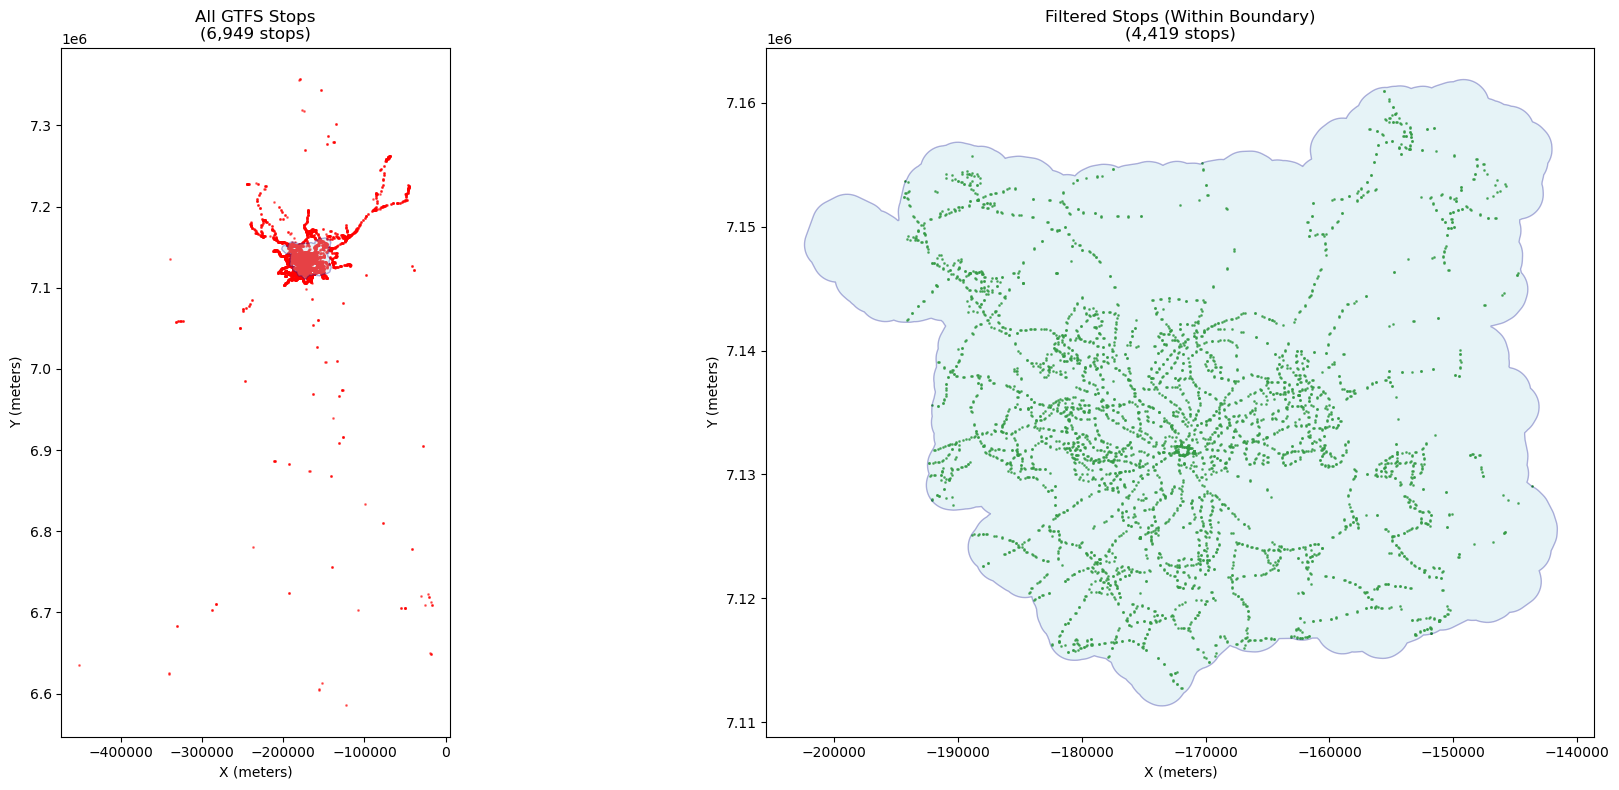

✅ Boundary filtering visualization created in EPSG:3857!
🗺️  All coordinates shown in meters (Web Mercator projection)


In [85]:
# Add this as another new cell - CORRECTED FOR EPSG:3857
if study_boundary is not None:
    print("\n=== TESTING BOUNDARY FILTERING ===")
    
    gtfs_feed = opt_data['reconstruction']['gtfs_feed']

    # Create stops GeoDataFrame for filtering
    stops_gdf = gpd.GeoDataFrame(
        gtfs_feed.stops,
        geometry=gpd.points_from_xy(gtfs_feed.stops.stop_lon, gtfs_feed.stops.stop_lat),
        crs="EPSG:4326"
    )
    
    print(f"📊 Original data:")
    print(f"   Total stops in GTFS: {len(stops_gdf)}")
    
    # Filter stops using boundary
    filtered_stops = study_boundary.filter_points(stops_gdf, output_crs="EPSG:3857")
    
    print(f"\n📊 After boundary filtering:")
    print(f"   Stops within study area: {len(filtered_stops)}")
    print(f"   Reduction: {len(stops_gdf) - len(filtered_stops)} stops ({100*(len(stops_gdf) - len(filtered_stops))/len(stops_gdf):.1f}%)")
    
    # Create a comparison visualization - ALL IN EPSG:3857
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Convert original stops to EPSG:3857 for consistent plotting
    stops_gdf_metric = stops_gdf.to_crs("EPSG:3857")
    
    # Plot 1: Original stops (converted to EPSG:3857)
    axes[0].scatter(stops_gdf_metric.geometry.x, stops_gdf_metric.geometry.y, 
                   c='red', alpha=0.5, s=1)
    study_boundary.visualize(ax=axes[0], viz_crs="EPSG:3857", 
                           facecolor='lightblue', alpha=0.3)
    axes[0].set_title(f'All GTFS Stops\n({len(stops_gdf):,} stops)')
    axes[0].set_xlabel('X (meters)')
    axes[0].set_ylabel('Y (meters)')
    
    # Plot 2: Filtered stops (already in EPSG:3857)
    axes[1].scatter(filtered_stops.geometry.x, filtered_stops.geometry.y, 
                   c='green', alpha=0.7, s=1)
    study_boundary.visualize(ax=axes[1], viz_crs="EPSG:3857", 
                           facecolor='lightblue', alpha=0.3)
    axes[1].set_title(f'Filtered Stops (Within Boundary)\n({len(filtered_stops):,} stops)')
    axes[1].set_xlabel('X (meters)')
    axes[1].set_ylabel('Y (meters)')
    
    # Set equal aspect ratio for both plots
    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Boundary filtering visualization created in EPSG:3857!")
    print(f"🗺️  All coordinates shown in meters (Web Mercator projection)")

In [87]:
# Add this as a new cell to test the integrated system
if study_boundary is not None:
    print("\n=== TESTING BOUNDARY-AWARE HEXAGONAL COVERAGE OBJECTIVE ===")
    
    # Create objective WITHOUT boundary (for comparison)
    spatial_objective_full = HexagonalCoverageObjective(
        optimization_data=opt_data,
        spatial_resolution_km=3.0,
        crs="EPSG:3857"
    )
    
    # Create objective WITH boundary
    spatial_objective_bounded = HexagonalCoverageObjective(
        optimization_data=opt_data,
        spatial_resolution_km=3.0,
        crs="EPSG:3857",
        boundary=study_boundary
    )
    
    print(f"\n📊 COMPARISON:")
    print(f"Full system:")
    print(f"   Zones: {len(spatial_objective_full.spatial_system.hex_grid)}")
    print(f"   Stops: {len(spatial_objective_full.spatial_system.stops_gdf)}")
    
    print(f"Bounded system:")
    print(f"   Zones: {len(spatial_objective_bounded.spatial_system.hex_grid)}")
    print(f"   Stops: {len(spatial_objective_bounded.spatial_system.stops_gdf)}")
    
    zone_reduction = len(spatial_objective_full.spatial_system.hex_grid) - len(spatial_objective_bounded.spatial_system.hex_grid)
    stop_reduction = len(spatial_objective_full.spatial_system.stops_gdf) - len(spatial_objective_bounded.spatial_system.stops_gdf)
    
    print(f"\nReduction from boundary:")
    print(f"   Zones: -{zone_reduction} ({100*zone_reduction/len(spatial_objective_full.spatial_system.hex_grid):.1f}%)")
    print(f"   Stops: -{stop_reduction} ({100*stop_reduction/len(spatial_objective_full.spatial_system.stops_gdf):.1f}%)")
    
    # Test evaluation
    bounded_analysis = spatial_objective_bounded.get_detailed_analysis(opt_data['initial_solution'])
    
    print(f"\n🎯 Bounded system analysis:")
    print(f"   Total vehicles: {bounded_analysis['total_vehicles']}")
    print(f"   Zones with service: {bounded_analysis['zones_with_service']}")
    print(f"   Spatial equity (variance): {bounded_analysis['variance']:.4f}")


=== TESTING BOUNDARY-AWARE HEXAGONAL COVERAGE OBJECTIVE ===
🗺️ Setting up spatial analysis with 3.0km resolution
🗺️  Reprojected 6949 stops to EPSG:3857
🔧 Creating 146 × 259 = 37814 grid cells
   Grid bounds: (-453051, 6584019) to (-15085, 7358492) meters
   Cell size: 3000.0m × 3000.0m
✅ Created 37814 hexagonal zones in EPSG:3857
🚀 Using spatial join for zone mapping...
✅ Mapped 6949 stops to zones
🚀 Pre-computing route-stop mappings...
✅ Cached stops for 278 routes/services
✅ Spatial system ready: 37814 hexagonal zones
🗺️ Setting up spatial analysis with 3.0km resolution
🗺️  Reprojected 6949 stops to EPSG:3857
🎯 Applying boundary filter to 6949 stops...
🔍 Filtered 6949 → 4419 points
✅ Filtered to 4419 stops within boundary
🔧 Creating 18 × 18 = 324 grid cells
   Grid bounds: (-195846, 7111259) to (-142157, 7162476) meters
   Cell size: 3000.0m × 3000.0m
✅ Created 324 hexagonal zones in EPSG:3857
🎯 Applying boundary filter to 324 grid cells...
🔍 Filtered 324 → 251 grid cells
✅ Filtere


=== VISUALIZING BOUNDARY-FILTERED SYSTEM ===


/tmp/ipykernel_2637968/1917776455.py:369: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2637968/1917776455.py:369: UserWarning: Glyph 128652 (\N{BUS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2637968/1917776455.py:369: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2637968/1917776455.py:369: UserWarning: Glyph 128652 (\N{BUS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


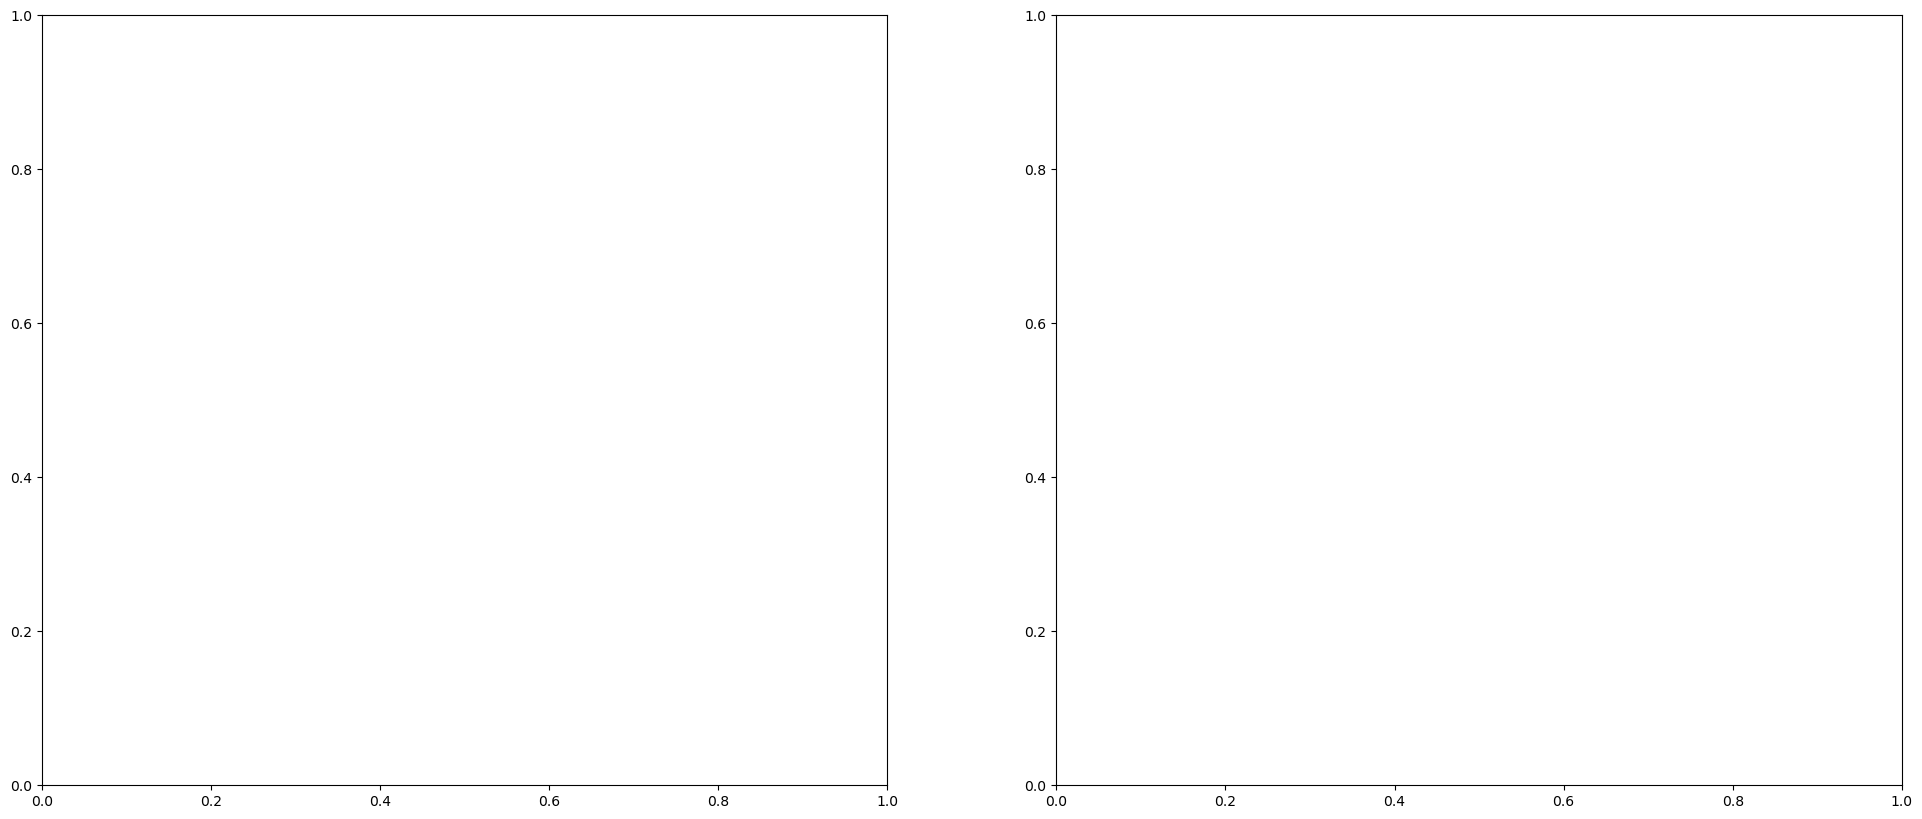

/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128652 (\N{BUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


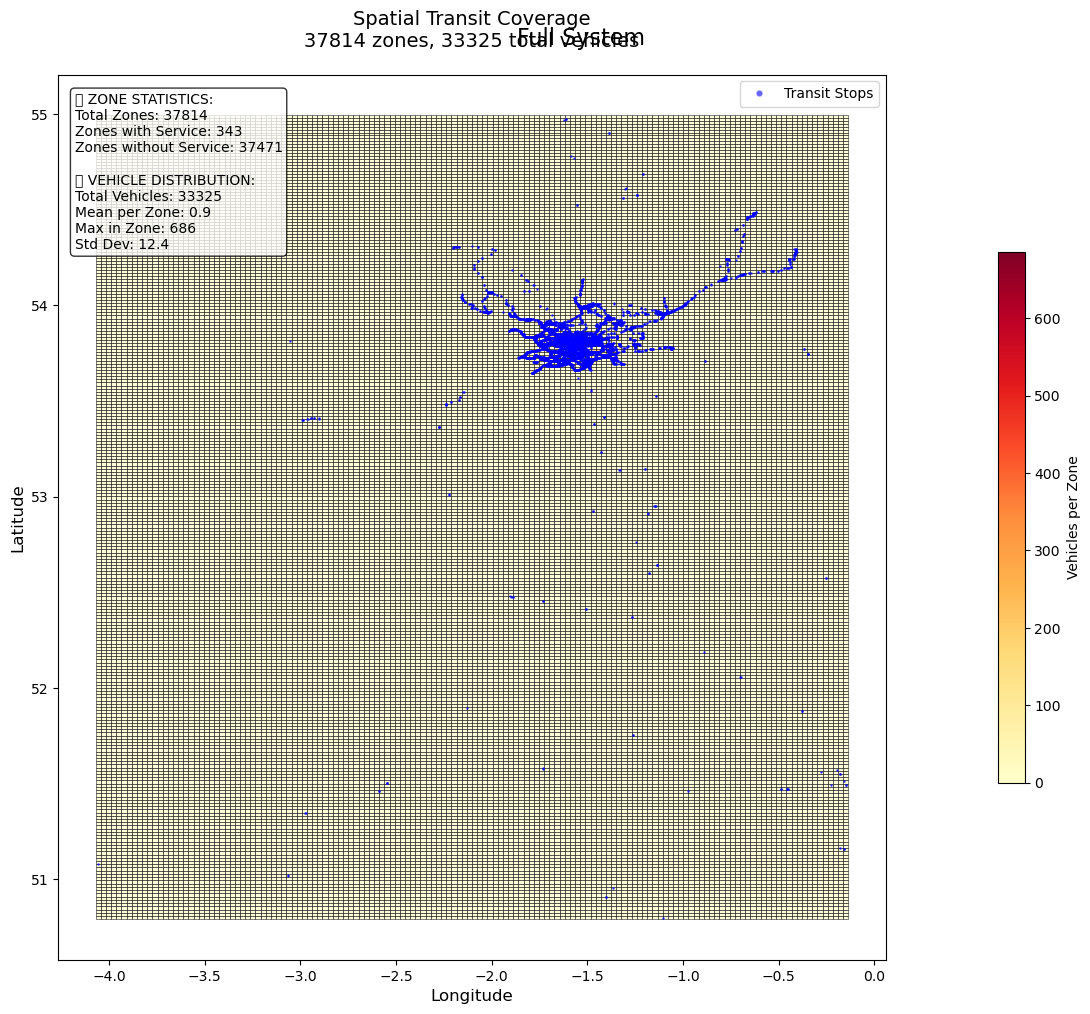

<Figure size 640x480 with 0 Axes>

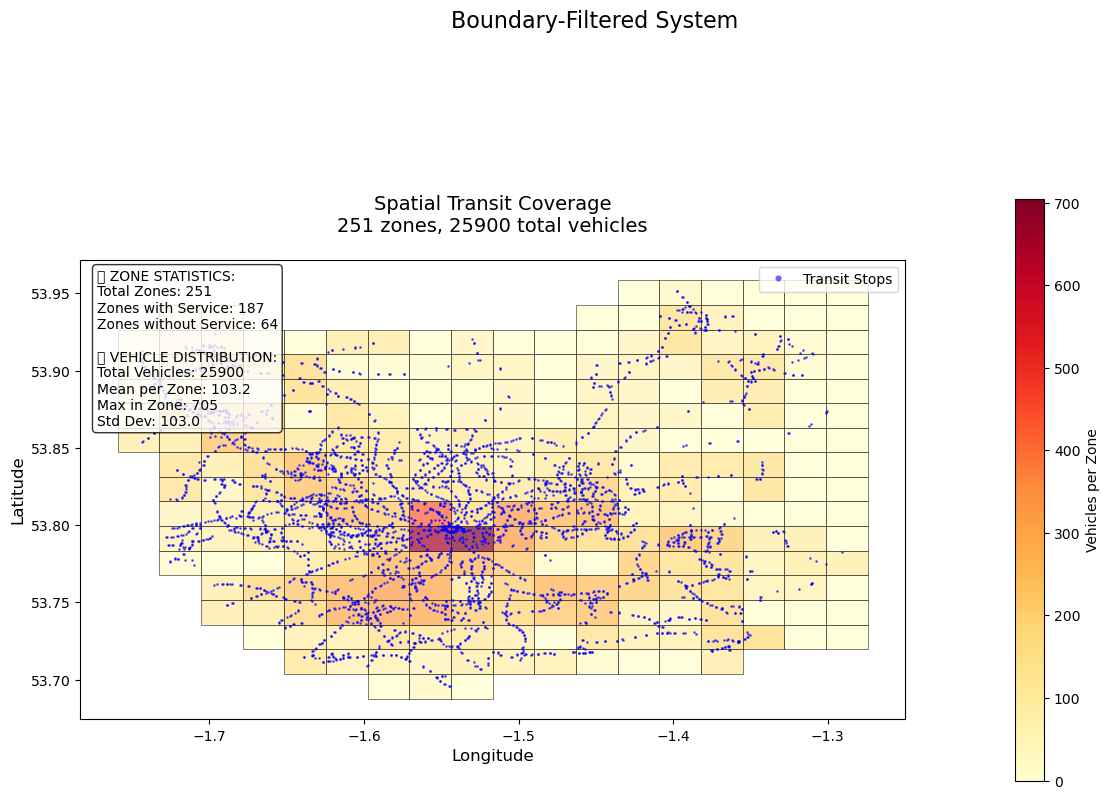

✅ Comparison visualization created!

💡 Benefits of boundary filtering:
   • Faster computation: 99.3% fewer zones to process
   • Focused analysis: Only considers relevant geographic area
   • Clearer visualizations: Removes outlying stops and zones
   • Better optimization: Concentrates on area of interest


In [88]:
# Add this cell for visualization
if study_boundary is not None:
    print("\n=== VISUALIZING BOUNDARY-FILTERED SYSTEM ===")
    
    # Create side-by-side comparison
    fig, axes = plt.subplots(1, 2, figsize=(24, 10))
    
    # Plot 1: Full system
    spatial_objective_full.spatial_system.visualize_spatial_coverage(
        solution_matrix=opt_data['initial_solution'],
        optimization_data=opt_data,
        figsize=(12, 10),
        show_stops=True,
        show_routes=False
    )
    plt.suptitle('Full System', fontsize=16)
    
    plt.figure()
    
    # Plot 2: Bounded system  
    spatial_objective_bounded.spatial_system.visualize_spatial_coverage(
        solution_matrix=opt_data['initial_solution'],
        optimization_data=opt_data,
        figsize=(12, 10),
        show_stops=True,
        show_routes=False
    )
    plt.suptitle('Boundary-Filtered System', fontsize=16)
    
    plt.show()
    
    print("✅ Comparison visualization created!")
    print(f"\n💡 Benefits of boundary filtering:")
    print(f"   • Faster computation: {100*zone_reduction/len(spatial_objective_full.spatial_system.hex_grid):.1f}% fewer zones to process")
    print(f"   • Focused analysis: Only considers relevant geographic area")
    print(f"   • Clearer visualizations: Removes outlying stops and zones")
    print(f"   • Better optimization: Concentrates on area of interest")

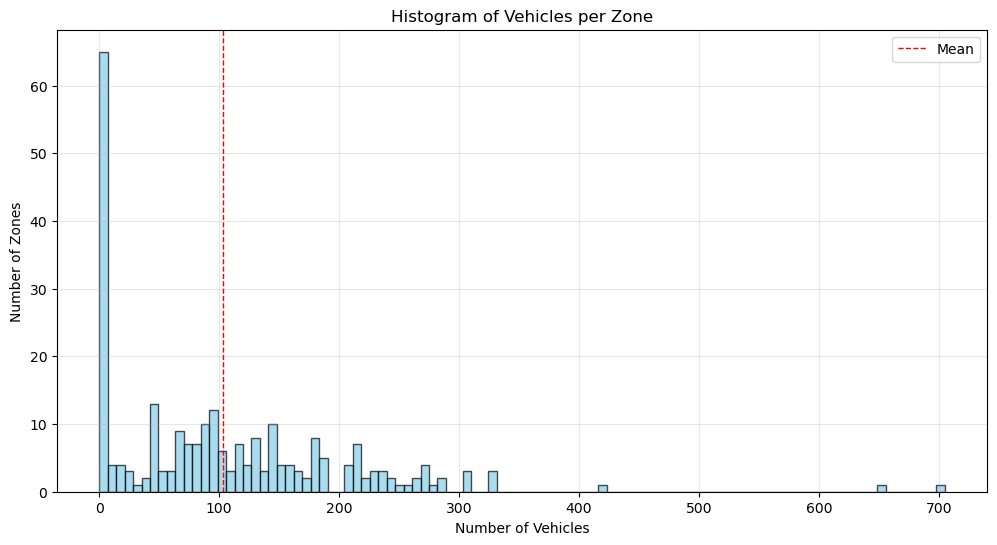

In [100]:
# Histogram showing number of vehicles per zone
plt.figure(figsize=(12, 6))
zone_stats = spatial_objective_bounded.get_detailed_analysis(opt_data['initial_solution'])
vehicles_per_zone = zone_stats['vehicles_per_zone']
n_bins = 100
plt.hist(vehicles_per_zone, bins=n_bins, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Vehicles per Zone')
plt.xlabel('Number of Vehicles')
plt.ylabel('Number of Zones')
plt.grid(True, alpha=0.3)
plt.axvline(np.mean(vehicles_per_zone), color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.legend()

